In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
df = pd.read_csv('/home/kevin/Downloads/Student Feedback Surveys-Superview.csv')

In [3]:
# Remove the few rows where rating errors out.
# was originally going to dropna but didnt want to lose all the other columns info.
df = df.loc[df['Rating (Num)'] != '#ERROR!']

In [4]:
df.loc[:, 'Rating (Num)'] = df.loc[:, 'Rating (Num)'].astype(int)

In [5]:
df.columns

Index(['ID', 'Location', 'Track', 'Week', 'Rating (Num)', 'Schedule Pacing'], dtype='object')

# Question 1: what is the number of responses as time goes on?

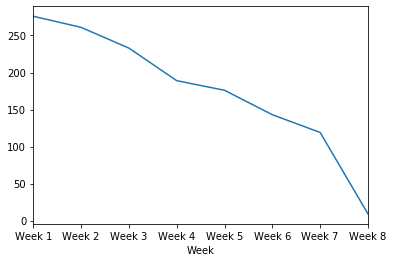

In [6]:
df.groupby('Week')['Track'].count().plot()

In [ ]:
# The dropoff in week 8 is so high I might consider dropping the week entirely to prevent missinformation

df = df.loc[df['Week'] != 'Week 8']

In [8]:
def promoter_level(rating):
    ''' Something to note is that there are 0's in the data 
    Despite the responses being from 1-10
    I feel like its because in the early phases it was 0-10, and in that case the data is still good.
    '''
    if rating < 0 or rating > 10:
        raise ValueError('Number out of bounds')
    
    if 9 <= rating <= 10:
        return 'Promoter'
    
    elif 7 <= rating <= 8:
        return 'Passive'
    
    else:
        return 'Detractor'

In [9]:
df['Category'] = df.loc[:, 'Rating (Num)'].apply(promoter_level)

### Calculate the nps scores

In [10]:
def calculate_nps(series):
    counts = series.value_counts()
    for kind in ['Promoter', 'Passive', 'Detractor']:
        if kind not in counts:
            counts[kind] = 0
    return (counts['Promoter'] - counts['Detractor']) / sum(counts) * 100

In [11]:
f"Overall NPS score: {calculate_nps(df['Category'])}"

'Overall NPS score: 43.85843164469119'

# Question 2: How does the NPS score change over the course of the program?
With overall nps score plotted in red

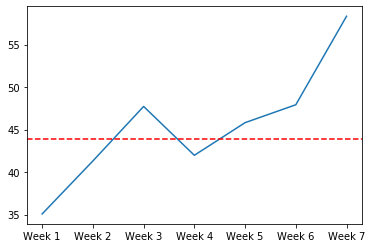

In [12]:
fig, ax = plt.subplots()
ax.plot(df.groupby('Week')['Category'].agg(calculate_nps))
ax.axhline(calculate_nps(df['Category']), color='r', linestyle='--')

# Question 3: How do the number of people in each category change over time?
with respect to the change in number of responses

In [13]:
pd.crosstab(df['Category'], df['Week'])

Week,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7
Category,,,,,,,
Detractor,28,23,20,19,15,8,8
Passive,131,116,86,74,67,59,34
Promoter,129,137,135,100,97,77,78


In [14]:
pd.crosstab(df['Track'], df['Week'])

Week,Week 1,Week 2,Week 3,Week 4,Week 5,Week 6,Week 7
Track,,,,,,,
Apps,183,176,142,105,101,88,72
"Apps, Explorer",42,40,38,34,31,23,16
Games,35,29,36,33,31,21,19
"Games, Explorer",6,6,7,7,6,6,5
VR,10,10,10,10,7,5,7


In [15]:
weekly_ratio = lambda cat: df.loc[df['Category'] == cat].groupby('Week')['Category'].count()/df.groupby('Week')['Category'].count()

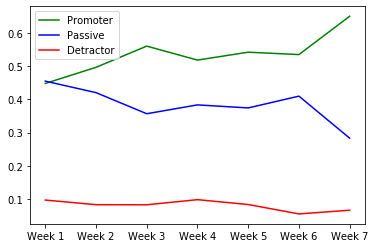

In [16]:
fig, ax = plt.subplots()
ax.plot(weekly_ratio('Promoter'), label='Promoter', c='Green')
ax.plot(weekly_ratio('Passive'), label='Passive', c='Blue')
ax.plot(weekly_ratio('Detractor'), label='Detractor', c='Red')

plt.legend()

## Take a look at pacing compared to category

In [72]:
# Turn the pacing into numerical form, counting from 0-2 depending on the perceived pacing

pacing_ord_map = {'Way too slow': 0, 'Way too fast': 0, 'A little too slow': 1, 'A little too fast': 1, 'Just right': 2}

In [19]:
df['schedule_ord'] = df['Schedule Pacing'].map(pacing_ord_map)

In [20]:
pd.crosstab(df['schedule_ord'], df['Category'], normalize='columns')

Category,Detractor,Passive,Promoter
schedule_ord,,,
0,0.099174,0.015873,0.006640
1,0.363636,0.317460,0.215139
2,0.537190,0.666667,0.778220


Well this is interesting, why did half the detractors say the pacing was just right??<br />
This leads me to believe there are other factors that are heavily affecting their enjoyment

In [31]:
pd.crosstab(df['Track'], df['schedule_ord'], normalize='index')

schedule_ord,0,1,2
Track,,,
Apps,0.014994,0.292964,0.692042
"Apps, Explorer",0.031250,0.232143,0.736607
Games,0.014706,0.215686,0.769608
"Games, Explorer",0.000000,0.116279,0.883721
VR,0.000000,0.254237,0.745763


In [34]:
detractors = df.loc[df['Category'] == 'Detractor']
pd.crosstab(detractors['schedule_ord'], detractors['Track'])

Track,Apps,"Apps, Explorer",Games,VR
schedule_ord,,,,
0,7,2,2,0
1,29,6,2,1
2,42,16,5,1


## Conclusion
A large part of the people who thought it was too fast or too slow were from the detractors <br />
But most detractors didn't seem to have a problem with the content.

# Question 4: How do people in each track like the program?

In [23]:
pd.crosstab(df['Track'], df['Category'], normalize='index')

Category,Detractor,Passive,Promoter
Track,,,
Apps,0.089965,0.409458,0.500577
"Apps, Explorer",0.107143,0.486607,0.406250
Games,0.044118,0.313725,0.642157
"Games, Explorer",0.000000,0.279070,0.720930
VR,0.033898,0.203390,0.762712


It looks like most tracks have high promoter counts, with app explorer falling the furthest behind.<br />
App comes in second. However they do both hold the highest number of people so theres a good chance <br />
Its a track for those who didnt really have a lot of passion.

In [24]:
pd.crosstab(df['Track'], df['schedule_ord'], normalize='index')

schedule_ord,0,1,2
Track,,,
Apps,0.014994,0.292964,0.692042
"Apps, Explorer",0.031250,0.232143,0.736607
Games,0.014706,0.215686,0.769608
"Games, Explorer",0.000000,0.116279,0.883721
VR,0.000000,0.254237,0.745763


Nobody had huge problems with the pacing, although only about 75% of people thought the pacing was just right

## Low correlation between rating and pacing

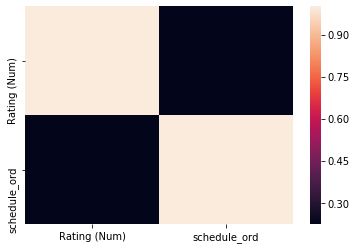

In [25]:
sns.heatmap(df[['Rating (Num)', 'schedule_ord']].corr())


# Question 5: How much do people like the program by location?

In [38]:
location_cats = pd.crosstab(df['Location'], df['Category'], normalize='index')

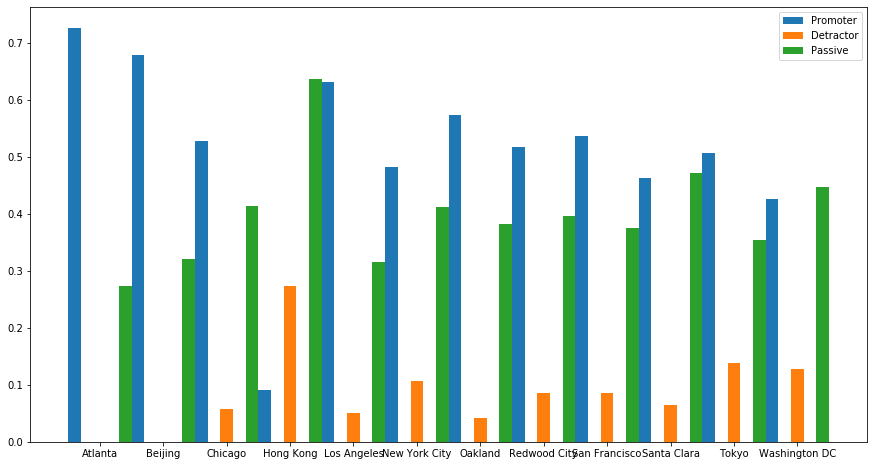

In [71]:
fig, ax = plt.subplots(figsize=(15, 8))

X = location_cats.index
_X = np.arange(len(X))
cats = [(-.4, 'Promoter'), (0, 'Detractor'), (.4, 'Passive')]
for offset, cat in cats:
    ax.bar(_X + offset, location_cats[cat], .2, label=cat)

plt.xticks(_X, X)
plt.legend()

Hong kong had some issues... But by people washington and NYC were also pretty bad!

# NPS scores by location

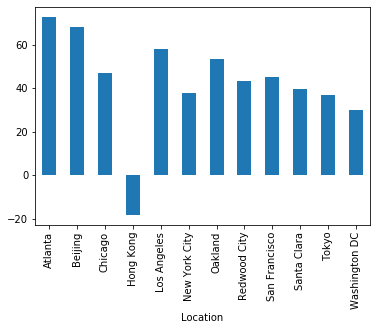

In [79]:
df.groupby('Location')['Category'].agg(calculate_nps).plot(kind='bar') axis=1